In [1]:
%matplotlib notebook

In [1]:
import pandas
import matplotlib.pyplot as mpl
import numpy as np
from scipy import stats
from iminuit import Minuit    
import warnings

In [2]:
fulldataframe = pandas.read_csv("../../Data/lssfr_paper_full_sntable.csv", sep=",")
df_snf = fulldataframe.loc[fulldataframe['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

In [3]:
class BaseModel( object ):
    FREEPARAMETERS = ["mu1","sigma1", "mu2", "sigma2", "a"]
    
    def setup(self, parameters):
        """ """
        self.parameters = {k:v for k,v in zip(self.FREEPARAMETERS, parameters)}
        
    # ============ #
    #  GETTER      #
    # ============ #
    def get_probabilities(self, x1, dx1, y):
        """ """
        mode_up   = self.get_modeup(x1, dx1) 
        mode_down = self.get_modedown(x1, dx1)
        return y * mode_up + (1-y) * (self.parameters["a"] * mode_up + (1-self.parameters["a"])*mode_down)
    
    def get_modeup(self, x1, dx1):
        """ """
        return stats.norm.pdf(x1, loc=self.parameters["mu1"], scale=np.sqrt(self.parameters["sigma1"]**2+dx1**2))
    
    def get_modedown(self, x1, dx1):
        """ """
        return stats.norm.pdf(x1, loc=self.parameters["mu2"], scale=np.sqrt(self.parameters["sigma2"]**2+dx1**2))
    
    
    def get_loglikelihood(self, x1, dx1, y):
        """ """
        probas = self.get_probabilities(x1, dx1, y)
        return np.log(probas)
    
    def get_pseudochi2(self, x1, dx1, y):
        """ """
        return -2* np.sum(self.get_loglikelihood(x1, dx1, y))
    
    
    
class Fitter( object ):
    
    def __init__(self, dataframe):
        """ """
        self.dataframe = dataframe
        self.model = BaseModel()
        
    # ============ #
    #  GETTER      #
    # ============ #
    def get_args(self, x1key="salt2.X1", dx1key="salt2.X1.err", ykey="p(prompt)"):
        """ """
        return self.dataframe[x1key], df_snf[dx1key], df_snf[ykey]
    
    def get_pseudochi2(self, mu1, sigma1, mu2, sigma2, a):
        """ """
        self.model.setup([mu1,sigma1, mu2, sigma2, a])
        pseudo_chi2 = self.model.get_pseudochi2(*self.get_args())
        #print(pseudo_chi2)
        return pseudo_chi2
    
    # ============ #
    #  FITTER      #
    # ============ #
    def fit(self, **kwargs):
        """ """
        self._setup_minuit_(**kwargs)
        self._migrad_output_ = self.minuit.migrad()
        
        if self._migrad_output_[0]["is_valid"] is False:
            warnings.warn("migrad is not valid")
            self.fitOk = False
        else:
            self.fitOk = True
            
        self.bestfit_params = np.asarray([self.minuit.values[k]
                              for k in self.model.FREEPARAMETERS])
        
    def setup_guesses(self, **kwargs):
        """ """
        self.param_input = {**{"mu1_guess":+1,"sigma1_guess":0.5,
                            "mu2_guess":-1,"sigma2_guess":0.5,
                            "a_guess":0.5,
                            "sigma1_boundaries":[0.01, 4],
                            "sigma2_boundaries":[0.01, 4],
                            "a_boundaries":[0,1]
                           }, 
                            **kwargs}
        return self.param_input

    def _setup_minuit_(self, step=0.001, print_level=0, **kwargs):
        """ **kwargs goes to setup_guesses 
            format: 
                - '`paramname`_guess'     = VALUE
                - '`paramname`_boundaries'= [MIN, MAX]
                - '`paramname`_fixed'     = BOOL                
        """
        self.setup_guesses(**kwargs)
        
        # == Minuit Keys == #
        minuit_kwargs = {}
        for param in self.model.FREEPARAMETERS:
            minuit_kwargs[param]           = self.param_input.get("%s_guess"%param,0)
            minuit_kwargs["limit_"+param]  = self.param_input.get("%s_boundaries"%param, [None,None])
            minuit_kwargs["fix_"+param]    = self.param_input.get("%s_fixed"%param, False)
            

        self.minuit = Minuit(self.get_pseudochi2,
                             print_level=print_level, errordef=step,
                             **minuit_kwargs)
        
            

In [4]:
base = Fitter(df_snf)

In [5]:
base.fit()

In [6]:
base.bestfit_params

array([ 0.40712464,  0.54982906, -1.38417257,  0.43878077,  0.48171466])

In [7]:
base.model.setup(base.bestfit_params)
np.sum(base.model.get_pseudochi2(df_snf["salt2.X1"], df_snf["salt2.X1.err"], df_snf["p(prompt)"]))

268.57681759344376

In [61]:
def show(self):
    """ """
    x1, dx1, y = self.get_args()
    
    fig = mpl.figure(figsize=[4,5])
    ax   = fig.add_axes([0.1,0.1,0.8,0.8])
    
    xx1 = np.linspace(-5,5,100)
    cmap = mpl.cm.viridis
    cvalue = {"young":0.01, "old":0.99}
    #
    # Histograms 
    #
    histprop=dict(orientation="horizontal", histtype="step", fill=True, range=(-3, 3), bins=14, density=False) 
    amp = (histprop['range'][1] - histprop['range'][0])/histprop['bins']
    # - Youngs 
    ax.hist(x1, weights=y, 
            facecolor=cmap(cvalue["young"], 0.2), 
            edgecolor="None", #mpl.cm.binary(0.7,0.2),#cmap(cvalue["young"], 0.8), 
            **histprop)
    # - Olds
    ax.hist(x1, weights=-(1-y), 
            facecolor=cmap(cvalue["old"],0.2), 
            edgecolor="None", #mpl.cm.binary(0.7,0.2), #cmap(cvalue["old"],0.8), 
            **histprop)
    #
    # Ideogram
    #
    # - Youngs 
    ax.plot( np.dot(y, stats.norm.pdf(xx1[:,None], loc=x1, scale=dx1).T)*amp, 
            xx1, color=cmap(cvalue["young"],0.8), ls="--")
    # - Olds
    ax.plot( -np.dot((1-y), stats.norm.pdf(xx1[:,None], loc=x1, scale=dx1).T)*amp,
            xx1, color=cmap(cvalue["old"],0.8), ls="--")

    # Models
    mode_up   =  self.model.get_modeup(xx1, np.median(dx1))*amp
    mode_down =  self.model.get_modedown(xx1, np.median(dx1))*amp
    # - Youngs
    ax.plot( mode_up*np.sum(y), xx1, ls="-", color=cmap(cvalue["young"],0.8))
    # - Olds
    ax.plot( - self.model.parameters["a"]*mode_up*np.sum(1-y), xx1, 
           ls="-", color=cmap(cvalue["old"],0.3))
    ax.plot( -(1-self.model.parameters["a"])*mode_down*np.sum(1-y), xx1,
           ls="-", color=cmap(cvalue["old"],0.3))
    ax.plot( -(self.model.parameters["a"]*mode_up + (1-self.model.parameters["a"])*mode_down)*np.sum(1-y), xx1,
            ls="-", color=cmap(cvalue["old"],0.8))
    
    ax.set_xlim(-25,25)
    ax.axvline(0, ls="-", color="k", lw=1)
    ax.set_frame_on(False)
    ax.set_yticks([])

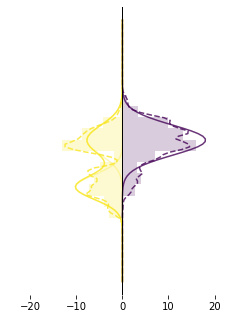

In [62]:
show(base)

In [58]:
6/14

0.42857142857142855